<a href="https://colab.research.google.com/github/wongwara/Jobseeker_Baymax/blob/main/Liao_Ya_Ping_24873414_week3_RandomForestClassifierRandomSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week 2 RandomForestClassifier

##### Import packages

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Kaggle_competition

/content/drive/MyDrive/Kaggle_competition


In [ ]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

<ipython-input-4-f017da97c504>:1: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('./train.csv')


##### Read CSV file

In [ ]:
df_train = pd.read_csv("./train.csv/train.csv")
df_test = pd.read_csv("./test.csv/test.csv")

C:\Users\annie\AppData\Local\Temp\ipykernel_11992\560797444.py:1: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("./train.csv/train.csv")


##### Define drop columns function

In [ ]:
def drop_columns(df_train, df_test):
    drop_columns = ["rimmade", "rimmade_rimmiss", "midmade", "midmade_midmiss", "rim_ratio", "mid_ratio", "dunksmade","dunksmiss_dunksmade", "dunks_ratio", "pick", "num", "type", "Rec_Rank", "player_id", ]
    df_train_cleaned = df_train.drop(columns = drop_columns, axis = 1)
    df_train_cleaned = df_train_cleaned.drop(columns = "drafted", axis = 1)
    df_test_cleaned = df_test.drop(columns = drop_columns, axis = 1)

    return df_train_cleaned, df_test_cleaned

##### Define one-hot encoding and label encoding function

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encoding(df_train, df_test):
    # One hot encoding - yr
    year_values = ["Fr", "So", "Jr", "Sr", "None"]
    df_train = df_train[df_train["yr"].isin(year_values)]
    df_train = pd.get_dummies(df_train, columns = ["yr"], prefix = ["yr"])
    df_test = pd.get_dummies(df_test, columns = ["yr"], prefix = ["yr"])

    # Label Encoding - team
    team_encoder = LabelEncoder()
    team_encoder.fit(df_train["team"])
    df_train["team"] = team_encoder.transform(df_train["team"])
    team_oov_labels = [label for label in df_test["team"] if label not in team_encoder.classes_] # Find Out-of-Vocabulary labels
    team_oov_code = len(team_encoder.classes_) # Handling Out-of-Vocabulary Labels
    team_encoder.classes_ = np.append(team_encoder.classes_, team_oov_labels)  # Add OOV labels to encoder classes
    df_test["team"] = np.where(np.isin(df_test["team"], team_encoder.classes_), team_encoder.transform(df_test["team"]), team_oov_code) # Transform test labels and handle OOV labels

    # Label Encoding - conf
    conf_encoder = LabelEncoder()
    conf_encoder.fit(df_train['conf'])
    df_train['conf'] = conf_encoder.transform(df_train['conf'])
    conf_oov_labels = [label for label in df_test['conf'] if label not in conf_encoder.classes_]
    conf_oov_code = len(conf_encoder.classes_)
    conf_encoder.classes_ = np.append(conf_encoder.classes_, conf_oov_labels)
    df_test["conf"] = np.where(np.isin(df_test["conf"], conf_encoder.classes_), conf_encoder.transform(df_test["conf"]), conf_oov_code)

    return df_train, df_test

#### Define scale data function

In [ ]:
from sklearn.preprocessing import StandardScaler
def scale_data (df_train, df_test):
    scaler = StandardScaler()
    df_train_scaled = scaler.fit_transform(df_train)
    df_test_scaled = scaler.transform(df_test)
    df_train_scaled = pd.DataFrame(df_train_scaled, columns = df_train.columns)
    df_test_scaled = pd.DataFrame(df_test_scaled, columns = df_test.columns)
    return df_train_scaled, df_test_scaled

In [ ]:
def handle_NAN(df_train, df_test):
    #tranform "ht" into float
    df_train['ht'].replace({None: np.nan}, inplace=True)
    df_test['ht'].replace({None: np.nan}, inplace=True)
    df_train['ht'] = pd.to_numeric(df_train['ht'], errors='coerce')
    df_test['ht'] = pd.to_numeric(df_test['ht'], errors='coerce')
    average_value_train = df_train['ht'].astype(float).mean()
    average_value_test = df_test['ht'].astype(float).mean()
    df_train['ht'].fillna(average_value_train, inplace=True)
    df_test['ht'].fillna(average_value_test, inplace=True)

    df_train["ht"] = pd.to_numeric(df_train["ht"])
    df_test["ht"] = pd.to_numeric(df_test["ht"])

    # Fills the missing values with 0
    df_train = df_train.fillna(0)
    df_test = df_test.fillna(0)
    return df_train, df_test

##### Define preprocessing function to deal with 'ht' and fill with the nan values.

In [ ]:
def preprocessing(df_train, df_test):
    # Drops some common columns to train and test data
    df_train, df_test = drop_columns(df_train, df_test)
    df_train, df_test = handle_NAN(df_train, df_test)
    df_train, df_test = encoding(df_train, df_test)

    return df_train, df_test

In [ ]:
# store the test data "player_id"
player_id = df_test[["player_id"]]
drafted = df_train[["drafted"]]

In [ ]:
df_train, df_test = preprocessing(df_train, df_test)

#### Draw box plot for each column.

In [ ]:
# df_train = pd.concat([df_train, drafted], axis = 0)
df_train["drafted"] = drafted

##### Deal with outlier

##### Define a function to remove outliers.

In [ ]:
def remove_outliers(df):
    outliers = pd.DataFrame(columns=df.columns)
    columns = ['Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'blk_per', 'stl_per', 'ftr', 'adjoe', 'pfr', 'adrtg', 'bpm', 'obpm', 'dbpm', 'gbpm', 'ogbpm' ]
    threshold=3

    for column in columns:
        mean = df[column].mean()
        std = df[column].std()

        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std

        outlier = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers = outliers.append(outlier)

        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df, outliers

In [ ]:
df_train, removed_outliers = remove_outliers(df_train)
outlier_count = removed_outliers.shape[0]

print("Number of removed outliers:", outlier_count)
print("Updated DataFrame shape:", df_train.shape)

<ipython-input-14-1bcc7aa9bb81>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(outlier)
<ipython-input-14-1bcc7aa9bb81>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(outlier)
<ipython-input-14-1bcc7aa9bb81>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(outlier)
<ipython-input-14-1bcc7aa9bb81>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(outlier)
<ipython-input-14-1bcc7aa9bb81>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  o

Number of removed outliers: 12240
Updated DataFrame shape: (43570, 54)


<ipython-input-14-1bcc7aa9bb81>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(outlier)
<ipython-input-14-1bcc7aa9bb81>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(outlier)
<ipython-input-14-1bcc7aa9bb81>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(outlier)
<ipython-input-14-1bcc7aa9bb81>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(outlier)
<ipython-input-14-1bcc7aa9bb81>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  o

##### Splite data set

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train
X = X.drop(columns = "drafted", axis = 1)
y = df_train["drafted"]

X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

##### Deal with imbalance data using over sampling.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 38)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

##### Import packages to train model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }

random_search = RandomizedSearchCV(model, param_distributions = param_dist)
random_search.fit(X_train_resampled, y_train_resampled)
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_
print(best_params_random)




/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

{'n_estimators': 61, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}


In [ ]:
best_model_random = RandomForestClassifier(**best_params_random)
best_model_random.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=61)

In [ ]:
train_pred_prob = best_model_random.predict_proba(X_train)[:, 1]
val_pred_prob = best_model_random.predict_proba(X_val)[:, 1]
test_pred_prob = best_model_random.predict_proba(X_test)[:, 1]

#### Caculate the AUROC score.

In [ ]:
train_auroc = roc_auc_score(y_train, train_pred_prob)
val_auroc = roc_auc_score(y_val, val_pred_prob)
test_auroc = roc_auc_score(y_test, test_pred_prob)

print(train_auroc)
print(val_auroc)
print(test_auroc)

0.9999991978695415
0.9697042783623934
0.975129034743086


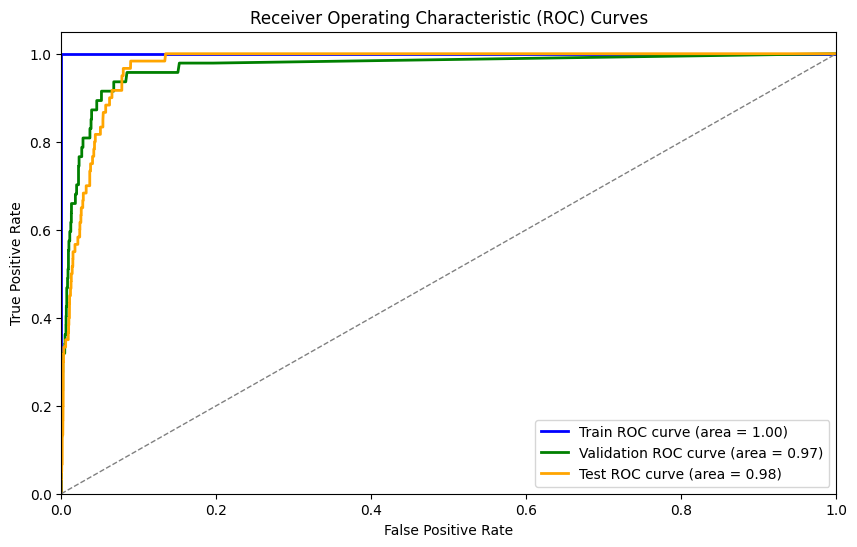

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
train_fpr, train_tpr, _ = roc_curve(y_train, train_pred_prob)
val_fpr, val_tpr, _ = roc_curve(y_val, val_pred_prob)
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob)

train_auc = auc(train_fpr, train_tpr)
val_auc = auc(val_fpr, val_tpr)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label='Train ROC curve (area = %0.2f)' % train_auc)
plt.plot(val_fpr, val_tpr, color='green', lw=2, label='Validation ROC curve (area = %0.2f)' % val_auc)
plt.plot(test_fpr, test_tpr, color='orange', lw=2, label='Test ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

##### Predict and output the prediction.

In [ ]:
x_new_test = df_test

In [ ]:
y_new_pred_proba = model.predict_proba(x_new_test)[:, 1]

In [ ]:
prediction_df = pd.DataFrame({"player_id": player_id["player_id"], "drafted": y_new_pred_proba})
print(prediction_df)

                                 player_id  drafted
0     cf302b4d-84f7-4124-a25d-a75eed31978b     0.00
1     f91837cd-4f49-4b70-963d-aeb82c6ce3da     0.00
2     53ec2a29-1e7d-4c6d-86d7-d60d02af8916     0.15
3     32402798-471c-4a54-8cb4-29cd95199014     0.00
4     73b960f9-27b8-4431-9d23-a760e9bbc360     0.01
...                                    ...      ...
4965  a25ee55f-02a3-4f8e-8194-a5f427e14e7c     0.00
4966  d0d9f45e-7b01-44b3-8d40-514ec338611d     0.00
4967  f8df22c4-1602-4fab-896d-8820951aae2f     0.00
4968  b791c69a-f769-4163-afda-051a6fd20a9d     0.00
4969  18b51f5d-4746-4121-88fd-c8d0a1399130     0.02

[4970 rows x 2 columns]


In [ ]:
prediction_df.to_csv( "prediction_results_6.csv", index=False)

In [ ]:
from google.colab import files
files.download("prediction_results_6.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>